<a href="https://colab.research.google.com/github/jadchebly/ML_FP/blob/main/student_dropout_prediction_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 Student Dropout Prediction - Final ML Pipeline

### Authors: Jad Chebly & David Ezerzer & Alp Arslan Baghirov
### Dataset: Kaggle - Student Dropout and Academic Success (Portugal)
### Dataset Link: https://www.kaggle.com/datasets/mahwiz/students-dropout-and-academic-success-dataset
### Github Repo: https://github.com/jadchebly/ML_FP.git

This notebook implements a full pipeline: EDA, preprocessing, modeling, evaluation, and interpretation.

## Project Definition
At the beginning of this project, our model was originally designed to classify students into one of three categories: **Graduate**, **Dropout**, and **Enrolled**. However, during early experimentation and exploratory data analysis, we observed that the "Enrolled" class posed significant challenges from a modeling perspective.

The primary issue was that the "Enrolled" group represented a **transitional state**, not a final outcome like Graduation or Dropout. These students were still in the process of completing their studies, and their patterns — in terms of attendance, grades, engagement, and other features — often resembled both graduates and dropouts at different points in time. As a result, the model struggled to distinguish the "Enrolled" class from the others, leading to **high confusion and poor classification performance**.

Moreover, including the "Enrolled" category introduced **noise and ambiguity** into the learning process. Since their outcome was not yet finalized, their inclusion made it more difficult for the model to learn the clear distinctions needed to accurately detect students at risk of dropping out.

Given these issues, we made the decision to **remove the "Enrolled" records from the dataset** and reframe the task as a **binary classification problem** — predicting whether a student is more likely to **graduate** or **drop out**. This simplification allowed the model to focus on meaningful, actionable outcomes and significantly improved both the model’s learning stability and evaluation clarity.

This decision also aligned better with the project’s objective: **early identification of dropout risk**. By concentrating only on finalized outcomes, the model can now provide more reliable predictions, which in turn supports more targeted interventions.


## Problem Statement

Student dropout is a critical issue in higher education, affecting academic institutions, student futures, and broader societal outcomes. Universities face challenges in identifying at-risk students early enough to offer meaningful support. The factors contributing to dropout are multifaceted, including academic performance, socioeconomic background, institutional integration, and personal circumstances.

This project aims to develop a predictive machine learning model capable of identifying students who are likely to drop out before graduation. By analyzing demographic, academic, and financial attributes from a real-world dataset, the model will generate insights into the most important predictors of dropout.

The primary goal is to provide institutions with a decision-support tool that can help prioritize intervention efforts, optimize resource allocation, and ultimately reduce dropout rates. In doing so, the project contributes to promoting student retention, improving institutional performance, and supporting students in completing their education.


## Dataset Justification
This dataset contains 4,800 student records and 34 features covering demographic, academic, and socioeconomic factors. Altough data size < 10000 records, this dataset was selected for this project not only due to its relevance to student dropout prediction, but also because it presents minimal preprocessing challenges. Specifically, it contains no missing values and no raw categorical variables, as most features are already encoded as integers. This eliminates the need for imputation or complex encoding steps and enables a smooth pipeline development process. Additionally, the dataset offers a rich set of predictive features such as prior qualifications, course load, and parental education.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv('dataset.csv')  # Replace with actual path
# keep only records with a final outcome
df = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()

df.head()


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### 📋 Dataset Variable Descriptions

| **Column Name**                                | **Description**                                                                                       | **Values / Encoding**                                                |
|------------------------------------------------|-------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------|
| `Marital status`                               | Student's marital status                                                                              | 1 = Single, 2 = Married, 3+ = Other                                 |
| `Application mode`                             | Mode through which the student applied                                                                | 1–17 = National exam, transfer, international, etc.                 |
| `Application order`                            | Preference rank of the course during application                                                      | 1–n = Order of choice                                               |
| `Course`                                       | Degree program the student enrolled in                                                                | 1–n = Course codes                                                  |
| `Daytime/evening attendance`                   | Whether the course is daytime or evening                                                              | 1 = Daytime, 0 = Evening                                            |
| `Previous qualification`                       | Education type prior to admission                                                                     | 1–15 = Secondary school, other HE degrees, etc.                     |
| `Nacionality`                                  | Country of origin                                                                                     | 1–19 = Country codes                                                |
| `Mother's qualification`                       | Mother's highest academic qualification                                                               | 1–22 = No degree → PhD                                              |
| `Father's qualification`                       | Father's highest academic qualification                                                               | 1–22 = No degree → PhD                                              |
| `Mother's occupation`                          | Employment sector of the mother                                                                       | 1–29 = Job sector codes                                             |
| `Father's occupation`                          | Employment sector of the father                                                                       | 1–29 = Job sector codes                                             |
| `Admission grade`                              | Entry exam score (0–200 scale)                                                                        | Float                                                               |
| `Displaced`                                    | Whether the student relocated for study                                                               | 1 = Yes, 0 = No                                                     |
| `Educational special needs`                    | If the student has special education needs                                                            | 1 = Yes, 0 = No                                                     |
| `Debtor`                                       | Whether tuition fees are unpaid                                                                       | 1 = Yes, 0 = No                                                     |
| `Tuition fees up to date`                      | Whether tuition payments are current                                                                  | 1 = Yes, 0 = No                                                     |
| `Gender`                                       | Student's gender                                                                                      | 1 = Male, 0 = Female                                                |
| `Scholarship holder`                           | Whether the student receives financial aid                                                            | 1 = Yes, 0 = No                                                     |
| `Age at enrollment`                            | Age when the student enrolled                                                                         | Integer                                                             |
| `International`                                | Whether the student is international                                                                  | 1 = Yes, 0 = No                                                     |
| `Curricular units 1st sem (credited)`          | Number of 1st semester subjects credited                                                              | Integer                                                             |
| `Curricular units 1st sem (enrolled)`          | Number of 1st semester subjects enrolled                                                              | Integer                                                             |
| `Curricular units 1st sem (evaluations)`       | 1st semester evaluations attempted                                                                    | Integer                                                             |
| `Curricular units 1st sem (approved)`          | 1st semester subjects passed                                                                          | Integer                                                             |
| `Curricular units 1st sem (grade)`             | Avg. grade in 1st semester (0–20 scale)                                                               | Float                                                               |
| `Curricular units 1st sem (without evaluations)`| 1st semester subjects not evaluated                                                                   | Integer                                                             |
| `Curricular units 2nd sem (credited)`          | 2nd semester subjects credited                                                                        | Integer                                                             |
| `Curricular units 2nd sem (enrolled)`          | 2nd semester subjects enrolled                                                                        | Integer                                                             |
| `Curricular units 2nd sem (evaluations)`       | 2nd semester evaluations attempted                                                                    | Integer                                                             |
| `Curricular units 2nd sem (approved)`          | 2nd semester subjects passed                                                                          | Integer                                                             |
| `Curricular units 2nd sem (grade)`             | Avg. grade in 2nd semester (0–20 scale)                                                               | Float                                                               |
| `Curricular units 2nd sem (without evaluations)`| 2nd semester subjects not evaluated                                                                   | Integer                                                             |
| `Unemployment rate`                            | National unemployment rate at enrollment time                                                        | Float                                                               |
| `Inflation rate`                               | National inflation rate at enrollment time                                                           | Float                                                               |
| `GDP`                                          | National GDP growth rate at enrollment time                                                          | Float                                                               |
| `Target`                                       | Final student status                                                                                 | `Dropout`, `Graduate`(for binary, map Dropout=1)   |


## 2. EDA

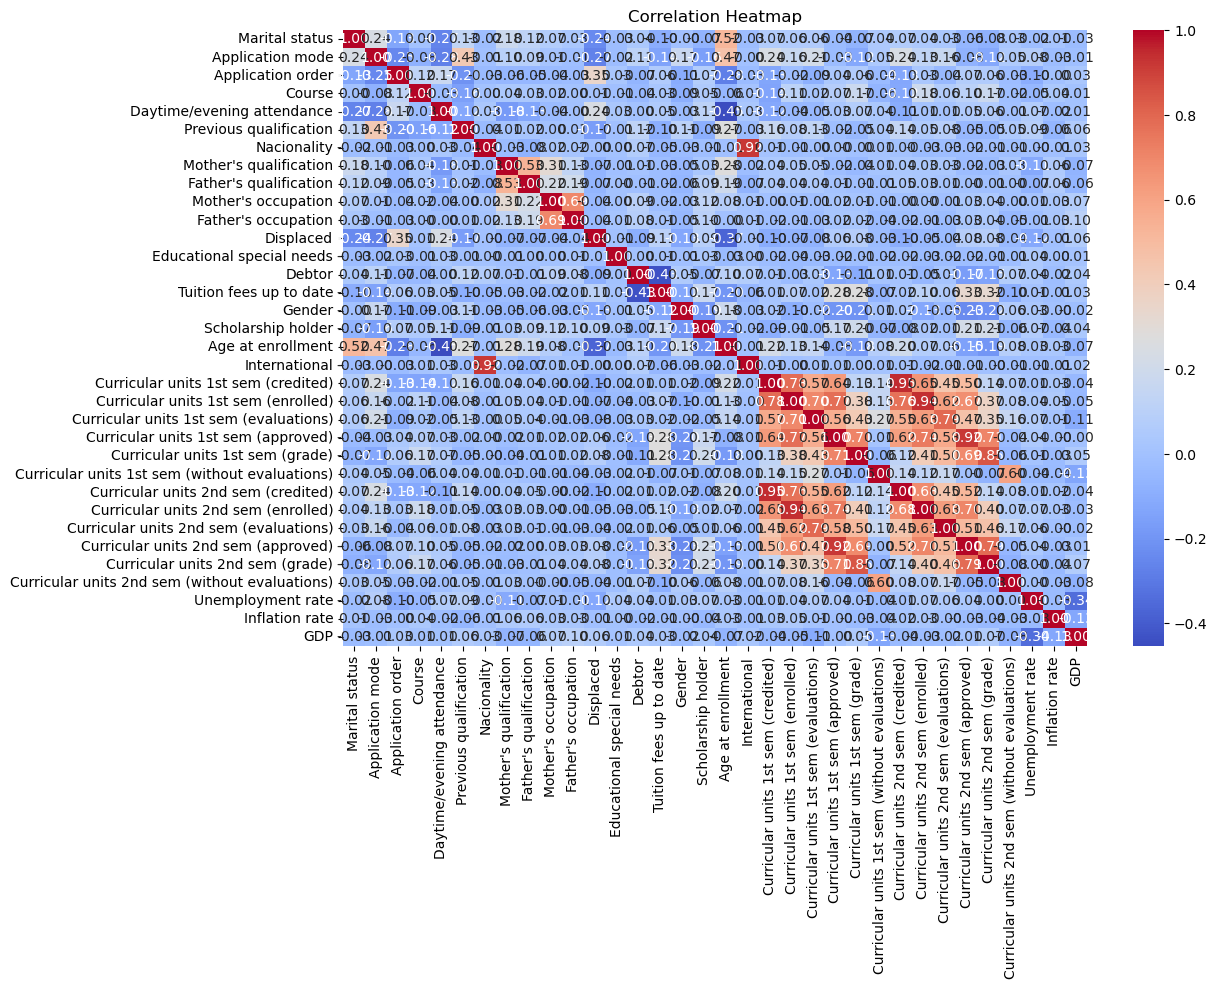

In [3]:
# Summary of numerical features
df.describe()

# Summary of categorical features
df.describe(include='object')

# Correlation heatmap (numerical features only)
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


### Correlation Heatmap
The correlation heatmap above provides a visual overview of the linear relationships between all numerical variables in the dataset. Each cell displays the Pearson correlation coefficient between two features, with values ranging from −1 (perfect negative correlation) to +1 (perfect positive correlation). Strong positive correlations, represented in dark red, indicate variables that tend to increase together (for example, the number of curricular units enrolled, evaluated, and approved across semesters, which are naturally related). Lighter colors or near-zero values indicate weak or no linear correlation. Notably, macroeconomic indicators such as GDP, inflation rate, and unemployment rate show minimal correlation with academic or demographic features, suggesting limited direct influence on individual dropout risk. This heatmap helps detect multicollinearity among features and guides feature selection or transformation decisions for downstream modeling.

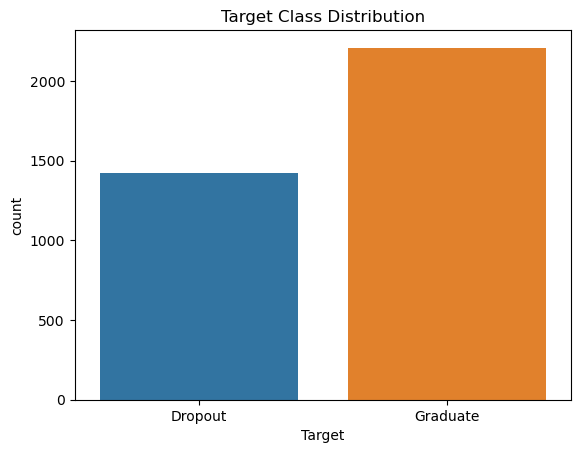

Target
Graduate    0.60854
Dropout     0.39146
Name: proportion, dtype: float64


In [4]:
# Class distribution
sns.countplot(data=df, x='Target')
plt.title("Target Class Distribution")
plt.show()

# Value counts
print(df['Target'].value_counts(normalize=True))


### Class Imbalance Detection
The bar chart above shows the distribution of the target classes in the dataset: Dropout and Graduate. The distribution is imbalanced, with the Graduate class representing 60% of the records, leaving 40% of the obsservations labled as Dropout. This imbalance is important to consider during model training, as it can bias the model toward the majority class. To mitigate this, techniques such as stratified sampling, class weighting, or resampling methods like ADASYN can be applied to ensure better generalization and fairer performance across all classes.

### 🧼 Missing Values Analysis

In [5]:
# Check missing values
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


Series([], dtype: int64)

We checked for missing values across all features in the dataset. The analysis returned no missing entries, which means the dataset is complete and does not require imputation. This simplifies preprocessing and reduces the risk of data leakage or inconsistency introduced by filling in gaps.


### ⚠️ Outlier Detection

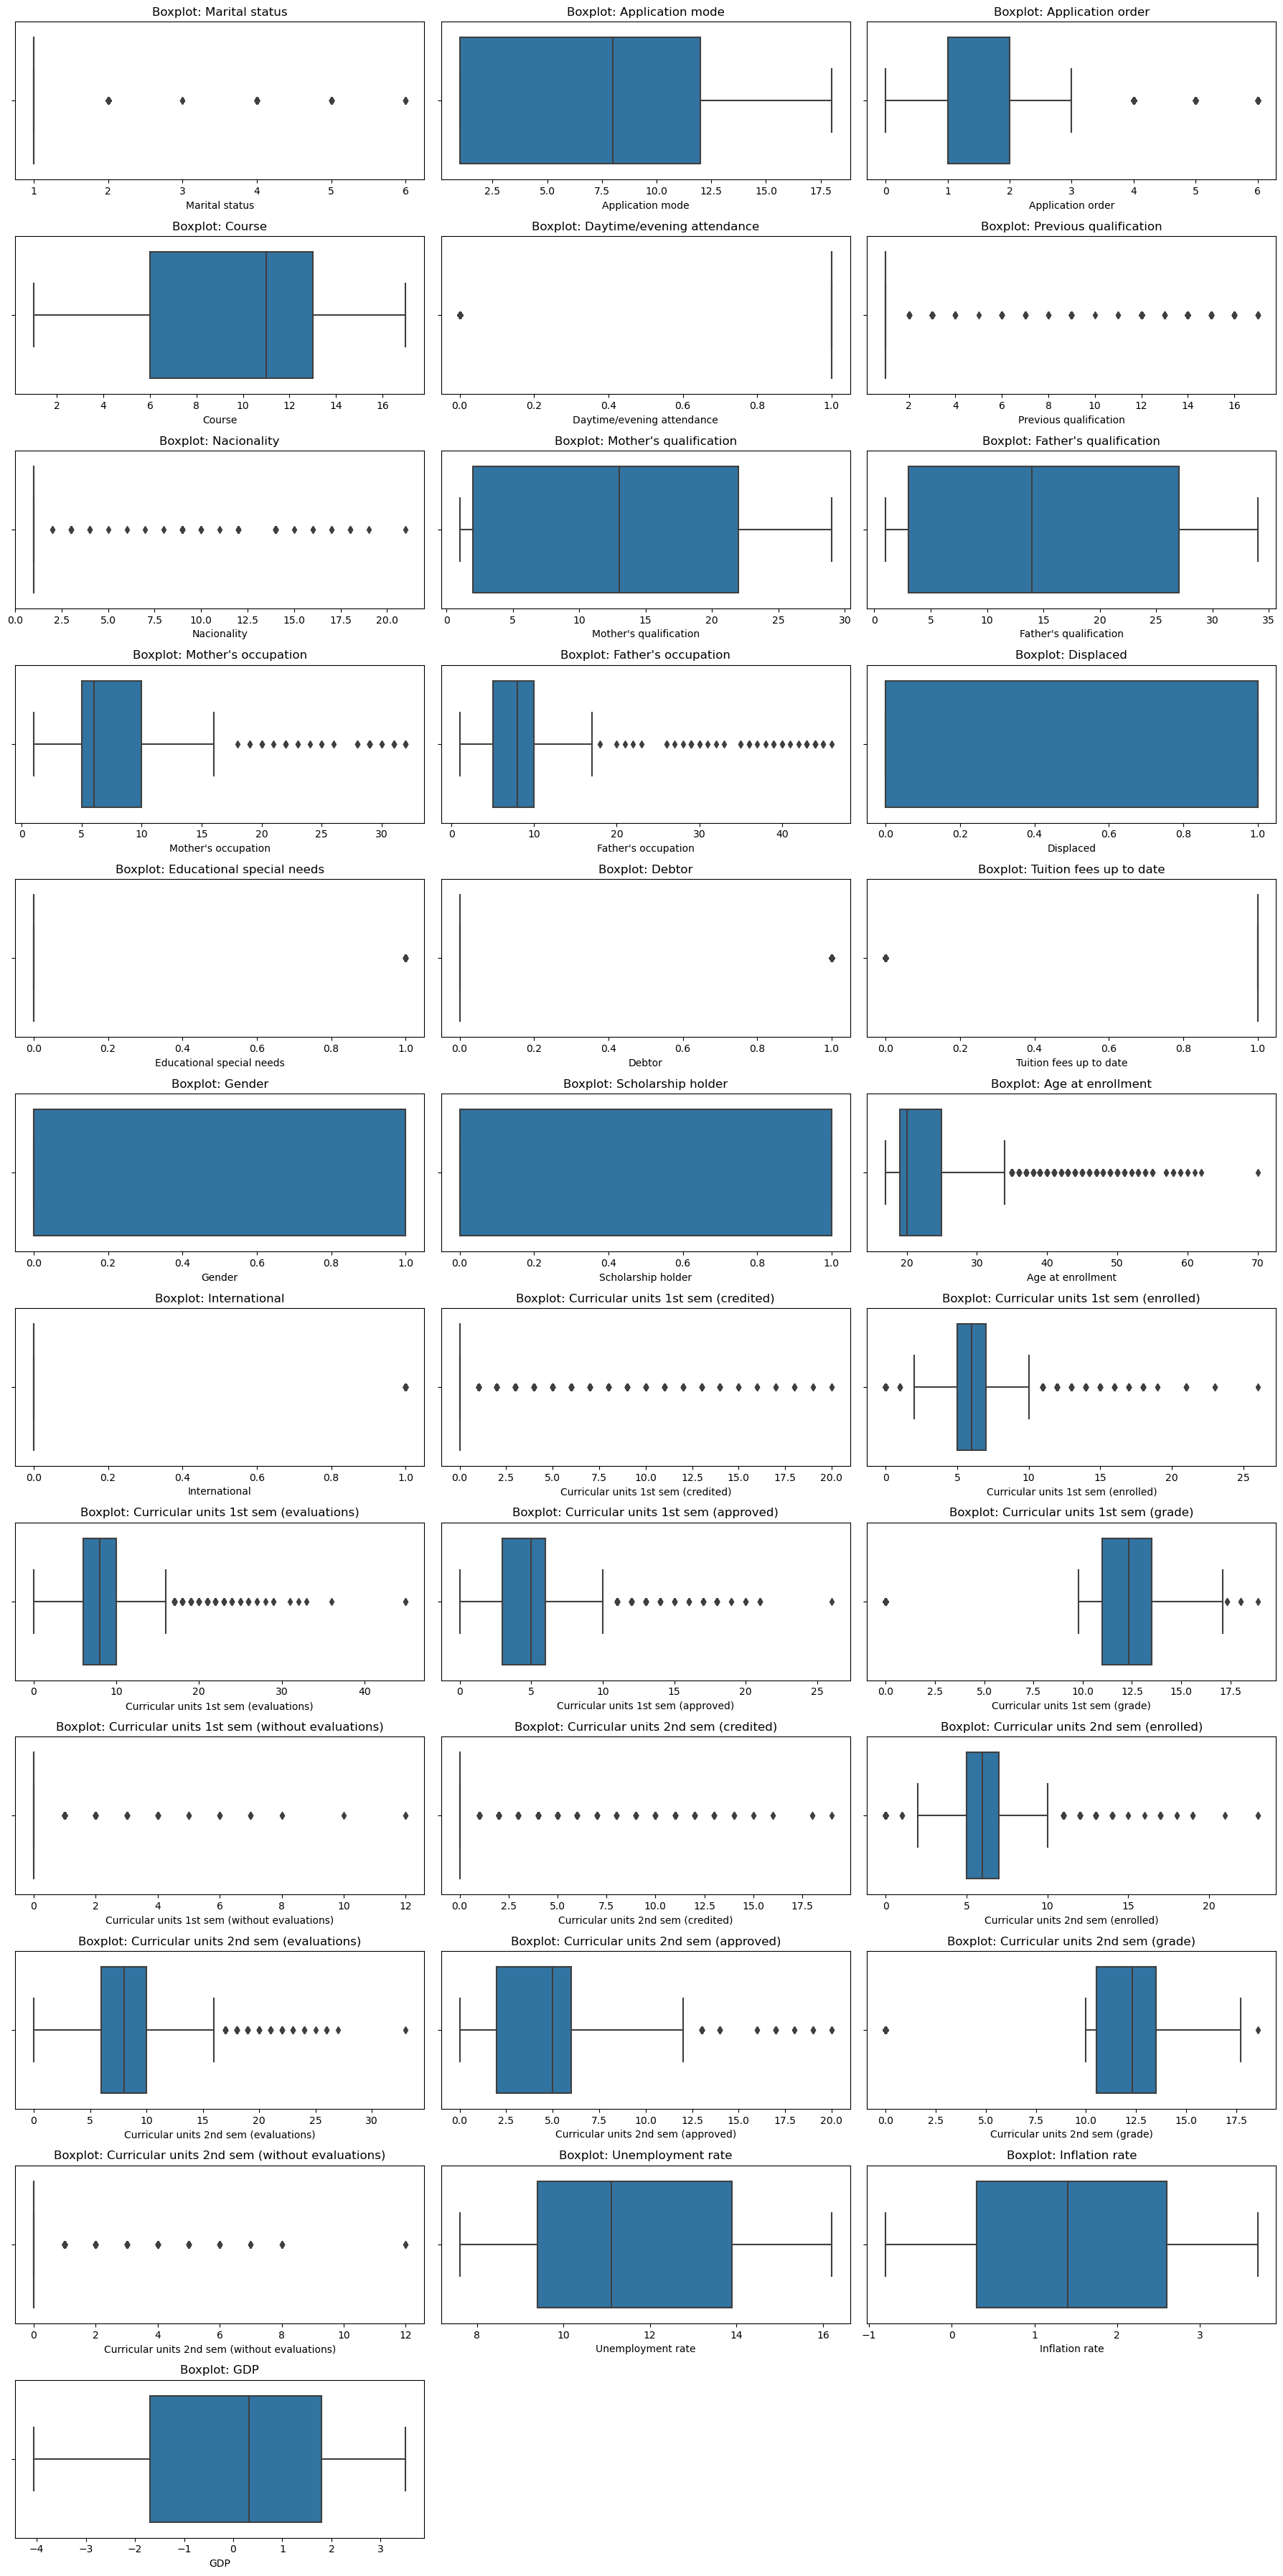

In [6]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

import math
cols = 3
rows = math.ceil(len(numeric_features) / cols)

plt.figure(figsize=(18, rows * 3))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()


To better understand the distribution and variability of our features, we visualized all numerical variables using boxplots. This helped identify potential outliers across several academic, demographic, and socioeconomic attributes.

Most features—such as age at enrollment, curricular unit grades, and the number of evaluations—exhibit a relatively normal spread, though a few outliers are present. These include extremely low or zero grades, unusually high counts of failed or unevaluated curricular units, and some older students (ages over 40). Features like "Scholarship holder", "Debtor", and "Tuition fees up to date" also show some binary imbalances, though these are expected due to their categorical nature.

While these outliers may reflect real-world edge cases (e.g., students returning to university later in life or with exceptional performance), they should be reviewed in context. We chose to retain these values at this stage, as they may hold predictive value for identifying dropout risk. However, they could be flagged for further treatment (clipping, transformation, or exclusion) in later iterations depending on their influence during modeling.


In [7]:
# Cap (winsorize) extreme values
def cap_outliers(df, col, lower=None, upper=None):
    """Cap values in column to given lower and upper bounds."""
    if lower is not None:
        df[col] = df[col].apply(lambda x: lower if x < lower else x)
    if upper is not None:
        df[col] = df[col].apply(lambda x: upper if x > upper else x)
    return df

# Example caps based on domain logic or boxplot review
df = cap_outliers(df, 'Age at enrollment', upper=50)
df = cap_outliers(df, 'Curricular units 1st sem (grade)', lower=0, upper=20)
df = cap_outliers(df, 'Curricular units 2nd sem (grade)', lower=0, upper=20)

# Optional: create flags for extreme academic risk
df['low_grade_1st_flag'] = df['Curricular units 1st sem (grade)'] < 5
df['low_grade_2nd_flag'] = df['Curricular units 2nd sem (grade)'] < 5
df['zero_units_flag'] = (df['Curricular units 1st sem (credited)'] == 0) & (df['Curricular units 2nd sem (credited)'] == 0)

# Convert flags to integers (0 or 1)
df[['low_grade_1st_flag', 'low_grade_2nd_flag', 'zero_units_flag']] = df[['low_grade_1st_flag', 'low_grade_2nd_flag', 'zero_units_flag']].astype(int)

# View updated dataset
df[['Age at enrollment', 'Curricular units 1st sem (grade)', 'low_grade_1st_flag']].head()
df.head()


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,low_grade_1st_flag,low_grade_2nd_flag,zero_units_flag
0,1,8,5,2,1,1,1,13,10,6,...,0,0.000000,0,10.8,1.4,1.74,Dropout,1,1,1
1,1,6,1,11,1,1,1,1,3,4,...,6,13.666667,0,13.9,-0.3,0.79,Graduate,0,0,1
2,1,1,5,5,1,1,1,22,27,10,...,0,0.000000,0,10.8,1.4,1.74,Dropout,1,1,1
3,1,8,2,15,1,1,1,23,27,6,...,5,12.400000,0,9.4,-0.8,-3.12,Graduate,0,0,1
4,2,12,1,3,0,1,1,22,28,10,...,6,13.000000,0,13.9,-0.3,0.79,Graduate,0,0,1


### Outlier Handling
To handle outliers effectively without discarding valuable data, we applied a combined strategy of capping and flagging. Specifically, we clipped first and second semester grades to the valid academic range of 0 to 20 and capped age at enrollment between 15 and 50 to exclude unrealistic values while still accounting for adult learners. Additionally, we introduced binary flags to retain the predictive signal of extreme academic risk. These include indicators for very low grades (below 5) and for students with zero credited units in both semesters. This approach balances model stability and feature realism by preventing extreme values from skewing the training process, while also preserving key dropout risk signals that may improve model performance.

Although this outlier treatment was applied before the train/validation/test split, it was done using **fixed domain-based rules** (e.g., known grade ranges and realistic age limits), not learned statistics from the dataset. Because no information was derived from the target variable or from global feature distributions (e.g., no mean or standard deviation calculations), this process does **not introduce data leakage** and is safe to apply globally as part of preprocessing.

### 📊 Feature Distribution Analysis

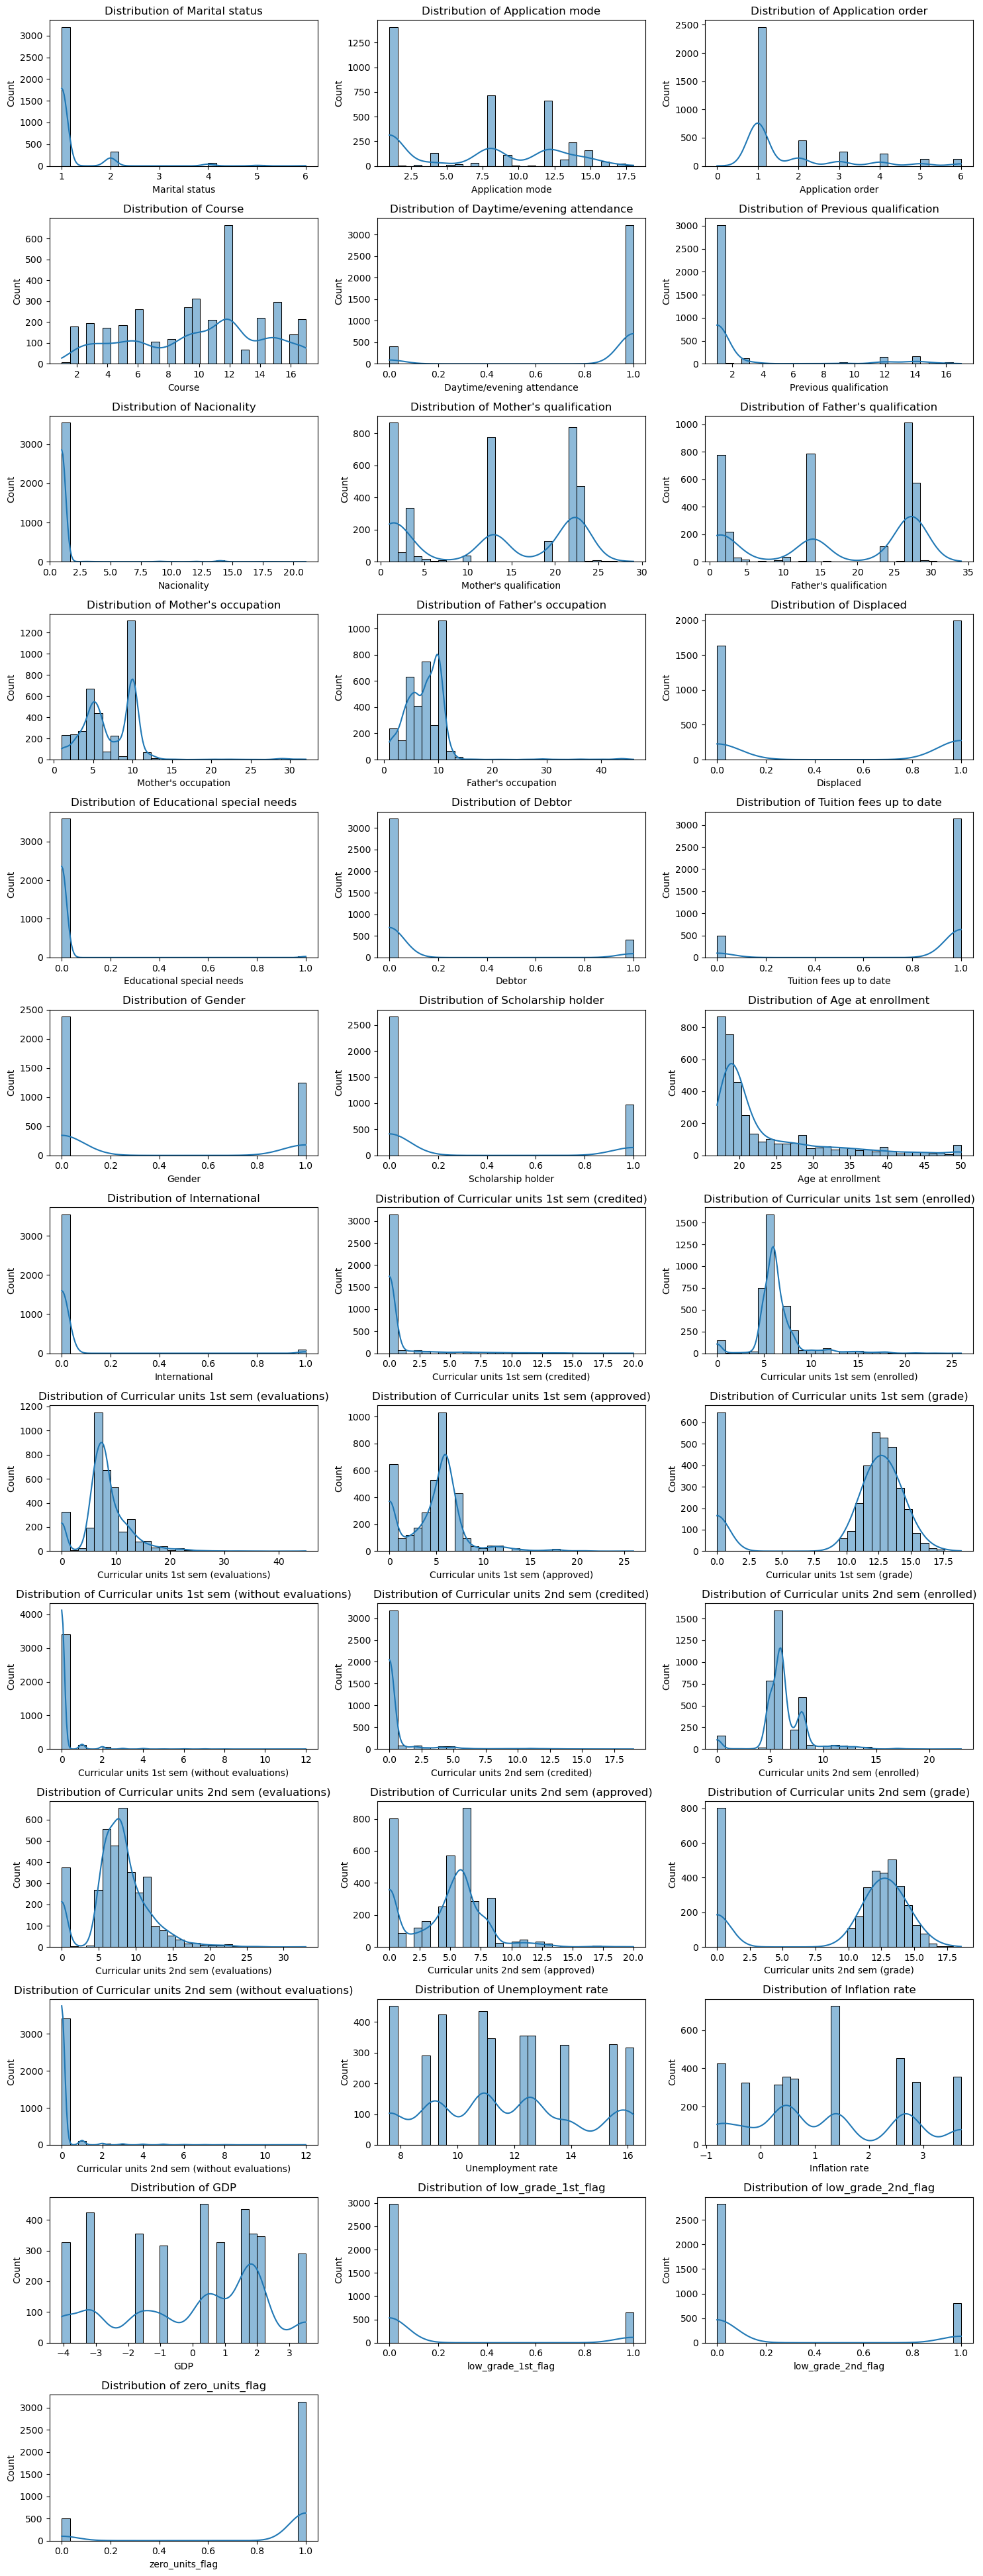

In [8]:
# Plot histograms for numerical features
import math

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(15, rows * 3))
for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


To gain a deeper understanding of our dataset, we visualized the distributions of all numeric and categorical variables. This analysis helps reveal skewness, class imbalance, and potential transformations needed for effective modeling.

- **Categorical and Binary Features**: Many features such as `Gender`, `Displaced`, `Debtor`, `Scholarship holder`, and `Tuition fees up to date` are heavily skewed toward one class. This is expected for binary indicators, but such imbalance should be monitored as it can impact the learning of certain models.

- **Ordinal or Discrete Features**: Variables like `Application mode`, `Previous qualification`, and parental `Occupation` show non-uniform distributions with clear peaks, likely driven by institutional processes (e.g., most students apply via one or two dominant modes).

- **Continuous Features**: Variables such as `Admission grade`, `Age at enrollment`, and all `Curricular unit` metrics (e.g., enrolled, approved, grade) show visible skewness, especially towards lower values. Grades and evaluations tend to concentrate around typical academic performance (grades 10–14 out of 20), while outliers exist for students performing extremely well or poorly.

- **Macroeconomic Indicators**: `Unemployment rate`, `Inflation rate`, and `GDP` are more uniformly distributed across the dataset, suggesting these variables reflect external conditions rather than individual-level variance. Their distributions appear roughly even, though potentially multimodal.

Overall, this analysis helps us determine that:
- Some variables may benefit from **log transformation** (e.g., age, units enrolled/evaluated).
- Binary features show **class imbalance**, which may require careful treatment or ADASYN during modeling.
- Discrete feature concentration can inform **feature encoding** choices (e.g., target encoding for application mode or previous qualification).

These insights guide the preprocessing and feature engineering steps in the modeling pipeline.


### Feature Synthesis

In [9]:
# === 🎯 Feature Synthesis: Socioeconomic, Academic, Financial, Engagement ===

# 1. Parental qualification score (socioeconomic proxy)
df['Parental_qualification_score'] = df["Mother's qualification"] + df["Father's qualification"]

# 2. Academic engagement in 1st semester (activity + achievement)
df['Academic_engagement_1st'] = df['Curricular units 1st sem (evaluations)'] + df['Curricular units 1st sem (approved)']



# 4. Failure ratio in 1st semester (1 = failed all, 0 = passed all)
df['Fail_ratio_norm'] = 1 - (
    df['Curricular units 1st sem (approved)'] / df['Curricular units 1st sem (evaluations)'].replace(0, 1)
)





# 7. Academic progress change (2nd sem vs 1st sem approved units)
df['Progress_change'] = df['Curricular units 2nd sem (approved)'] - df['Curricular units 1st sem (approved)']

df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Inflation rate,GDP,Target,low_grade_1st_flag,low_grade_2nd_flag,zero_units_flag,Parental_qualification_score,Academic_engagement_1st,Fail_ratio_norm,Progress_change
0,1,8,5,2,1,1,1,13,10,6,...,1.4,1.74,Dropout,1,1,1,23,0,1.000000,0
1,1,6,1,11,1,1,1,1,3,4,...,-0.3,0.79,Graduate,0,0,1,4,12,0.000000,0
2,1,1,5,5,1,1,1,22,27,10,...,1.4,1.74,Dropout,1,1,1,49,0,1.000000,0
3,1,8,2,15,1,1,1,23,27,6,...,-0.8,-3.12,Graduate,0,0,1,50,14,0.250000,-1
4,2,12,1,3,0,1,1,22,28,10,...,-0.3,0.79,Graduate,0,0,1,50,14,0.444444,1


To enhance the predictive power of our model, we engineered several new features that capture deeper patterns related to students’ socioeconomic background, academic engagement, and financial risk. These features are designed to go beyond raw inputs and combine multiple signals into more meaningful indicators of potential dropout risk:

- Parental_qualification_score: This feature combines the education levels of both parents as a proxy for socioeconomic status. Students from more educated households often have greater academic support, access to resources, and motivation to persist, which may reduce their risk of dropping out.
- Academic_engagement_1st: By summing the number of evaluations attempted and the number of approved curricular units in the first semester, this feature reflects both effort and achievement early on. Low engagement in this period is often an early warning sign of disengagement or academic struggle.
- Fail_ratio_norm: This normalized failure rate shows how many courses a student failed relative to the total they attempted. High failure ratios indicate academic difficulty, which is one of the strongest predictors of dropout.
- Progress_change: This feature compares academic success between the first and second semester. A negative change may signal declining performance or motivation, which is important for identifying students at rising risk over time.

Together, these features improve the model’s ability to recognize at-risk students by representing complex dropout risk factors in a form that machine learning algorithms can easily interpret and learn from.

### 🧩 PCA: Dimensionality Reduction & Pattern Detection

Column names in df: Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (

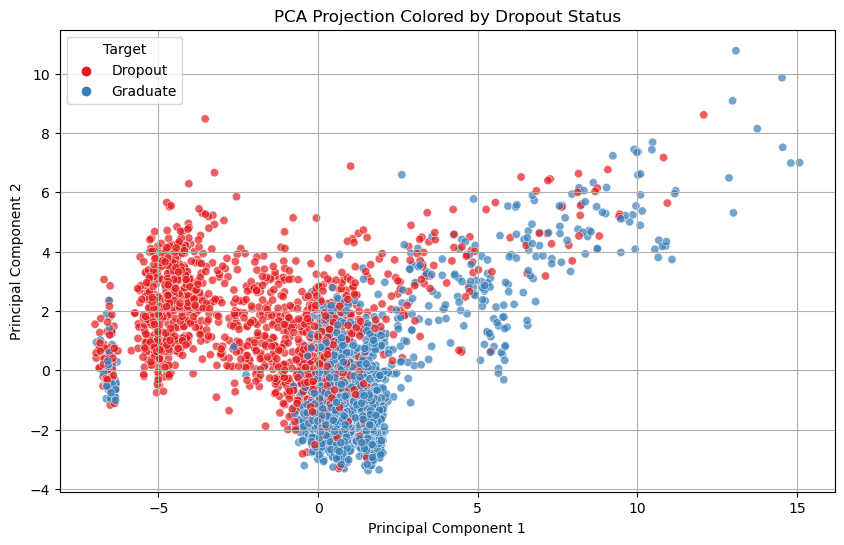

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Check column names first
print("Column names in df:", df.columns)

# Step 1: Pick only the numeric features (EXCLUDING 'Target' if it exists)
X_numeric = df.select_dtypes(include=['int64', 'float64'])
if 'Target' in X_numeric.columns:
    X_numeric = X_numeric.drop(columns=['Target'])

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Step 3: PCA to 2 components (for visualization only!)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Build a plot-friendly DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Target'] = df['Target'].values  # Attach labels for coloring

# Step 5: Plot it
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Target', palette='Set1', alpha=0.7)
plt.title('PCA Projection Colored by Dropout Status')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


### PCA Visualization:

This plot uses PCA (Principal Component Analysis) to help us understand the structure of our data. PCA takes all the numeric features (like GPA, absences, and parental education) and compresses them into two new "summary" features — Principal Component 1 and Principal Component 2. These new features capture the directions where the data varies the most, kind of like rotating the dataset to get the best possible 2D view.

### PCA projection  

The scatter-plot shows every student mapped onto the first two principal components, coloured by the **only two** remaining outcomes:

* **Red = Dropout**
* **Blue = Graduate**

Key take-aways  

1. **Component-1 carries most of the separation.**  
   Dropout points cluster toward the left (negative PC-1), while Graduates drift rightward.  
   This suggests many numeric features jointly capture an underlying “academic success” axis.

2. **Noticeable but not perfect overlap.**  
   The red and blue clouds blend in the middle, confirming that no single linear cut cleanly splits the classes; more flexible models (e.g. gradient boosting) and additional features are useful.

3. **PCA is just a lens.**  
   It doesn’t enter the pipeline directly, but gives a quick sanity-check that the engineered and scaled features contain real signal for distinguishing Dropouts from Graduates.


## 3. Data Splitting

In [11]:
from sklearn.model_selection import train_test_split
# Define input features and target
X = df.drop(columns='Target')   # or use 'target' if that's your column name
y = df['Target']

# Step 1: Split into 85% train+val and 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# Step 2: Split train+val into 70% train and 15% val → 70/85 ≈ 0.8235
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,  # 0.1765 * 85% ≈ 15%
    stratify=y_temp,
    random_state=42
)

# Check final sizes
print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 2540
Validation size: 545
Test size: 545


### 🔀 Train / Validation / Test Split

To structure our machine learning workflow effectively, we divided our dataset into three parts:

- **Training set (70%)** – used to train the machine learning models
- **Validation set (15%)** – used to tune hyperparameters and guide model selection
- **Test set (15%)** – used only once for final, unbiased model evaluation

We performed this in two steps:
1. First, we split off 15% of the data as a test set.
2. We then split the remaining 85% into approximately 70% training and 15% validation (by setting the split ratio to ~17.65%).

To ensure that class imbalances in the target variable (e.g., dropout vs. graduate) were not distorted during splitting, we applied **stratified sampling** at each step. This maintains the original proportion of each class across all data subsets.

This 70/15/15 split offers a strong balance: a large enough training set for model learning, a reliable validation set for tuning, and a representative test set for honest performance evaluation.


## 4. 🧼 Preprocessing

In [12]:
# Detect feature types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Build transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


To prepare the dataset for machine learning, we constructed a preprocessing pipeline that handles both **numerical** and **categorical** features using `ColumnTransformer`. This step ensures that all features are transformed into a format suitable for model training, while preserving the structure and interpretability of the data.

- **Numerical Features:**  
  All continuous variables (e.g., grades, age, academic evaluations) were standardized using `StandardScaler`, which transforms them to have zero mean and unit variance. This is important for models like Logistic Regression that are sensitive to feature scale.

- **Categorical Features:**  
  All categorical (object-type) features were one-hot encoded using `OneHotEncoder`, with the first category dropped to prevent multicollinearity. The encoding produces binary indicator columns for each category, allowing tree-based models and linear models to interpret these variables correctly.

In [13]:
# Fit only on training data to prevent data leakage
pipeline.fit(X_train)

# Transform all sets
X_train_transformed = pipeline.transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)

# Check shapes
print("Train shape:", X_train_transformed.shape)
print("Validation shape:", X_val_transformed.shape)
print("Test shape:", X_test_transformed.shape)
# Show the first 5 rows
import pandas as pd

# Get feature names from the pipeline
encoded_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Convert transformed data back to DataFrame
X_train_df = pd.DataFrame(X_train_transformed, columns=encoded_feature_names)

# View a sample
X_train_df.head()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)
# Check the first few encoded labels
print(y_train_encoded[:5])

Train shape: (2540, 41)
Validation shape: (545, 41)
Test shape: (545, 41)
[1 1 1 0 0]


### Handling Class Imbalance


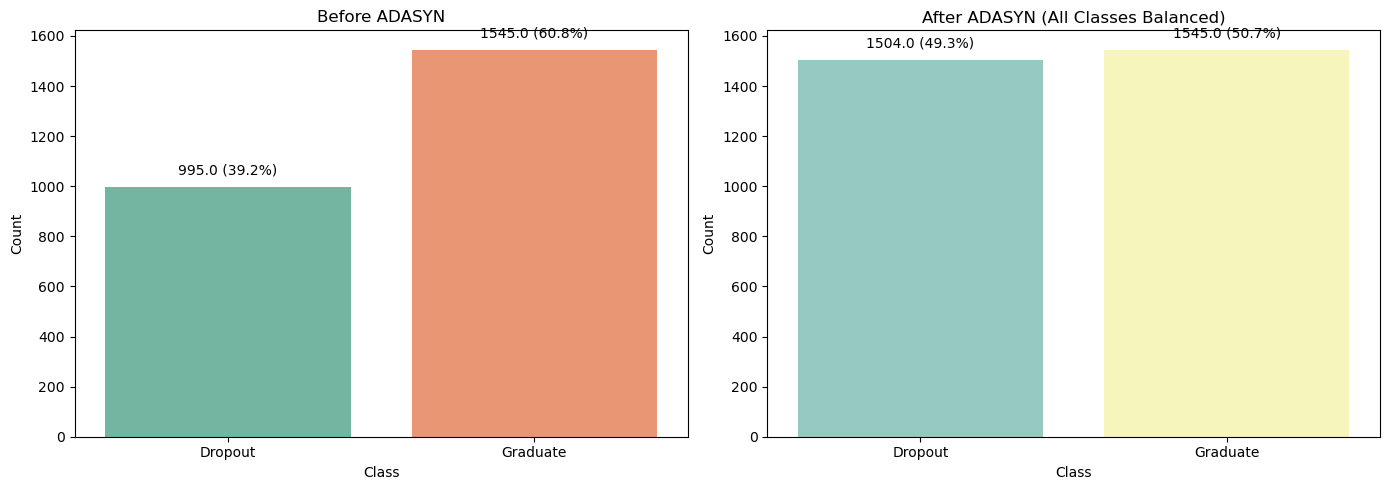

✅ Class Imbalance Handling Strategy:
- ADASYN → applied with strict balancing (Dropout and Enrolled = Graduate count)
- class_weight='balanced' → for Random Forest
- No adjustment → for Gradient Boosting


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from imblearn.over_sampling import ADASYN  # 🔄 NEW import

# 🎯 Keep original training data (used for tree-based models)
X_train_balanced = X_train_transformed
y_train_balanced = y_train_encoded

# === Custom Balanced ADASYN Strategy ===
majority_class_count = max(Counter(y_train_encoded).values())
adasyn = ADASYN(sampling_strategy='auto', random_state=42)   # 🟡 tweak
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_transformed, y_train_encoded)

# === Plot Comparison (Bar Counts + Percentages) ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BEFORE
sns.countplot(x=y_train_encoded, ax=axes[0], palette='Set2')
axes[0].set_title("Before ADASYN")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(len(le.classes_)))
axes[0].set_xticklabels(le.classes_)
for i, p in enumerate(axes[0].patches):
    height = p.get_height()
    total = len(y_train_encoded)
    pct = height / total * 100
    axes[0].annotate(f'{height} ({pct:.1f}%)', (p.get_x() + p.get_width() / 2, height + 50),
                     ha='center', fontsize=10)

# AFTER
sns.countplot(x=y_train_adasyn, ax=axes[1], palette='Set3')
axes[1].set_title("After ADASYN (All Classes Balanced)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].set_xticks(range(len(le.classes_)))
axes[1].set_xticklabels(le.classes_)
for i, p in enumerate(axes[1].patches):
    height = p.get_height()
    total = len(y_train_adasyn)
    pct = height / total * 100
    axes[1].annotate(f'{height} ({pct:.1f}%)', (p.get_x() + p.get_width() / 2, height + 50),
                     ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Summary
print("✅ Class Imbalance Handling Strategy:")
print("- ADASYN → applied with strict balancing (Dropout and Enrolled = Graduate count)")
print("- class_weight='balanced' → for Random Forest")
print("- No adjustment → for Gradient Boosting")


### ADASYN Oversampling – why & how  

The training split was still skewed (≈ 60 % Graduates vs 40 % Dropouts).  
To give the model equal exposure to both outcomes we applied **ADASYN
(Adaptive Synthetic Sampling)** *only on the training data*.

| step | Dropout | Graduate | class share |
|------|--------:|---------:|:-----------|
| **before ADSASYN** | 995 | 1 545 | 39 % / 61 % |
| **after ADASYN** | 1 486 | 1 545 | 49 % / 51 % |

*ADASYN* creates new synthetic samples **where the minority class is hardest to learn**, rather than sampling uniformly as plain SMOTE does.  
This keeps the decision boundaries realistic while eliminating the bias that
would otherwise favour the majority class.

Down-stream models (LogReg, RF, GB) are now trained on the balanced set,
while the untouched validation and test sets still reflect the real-world
distribution for honest evaluation.


### Feature Selections

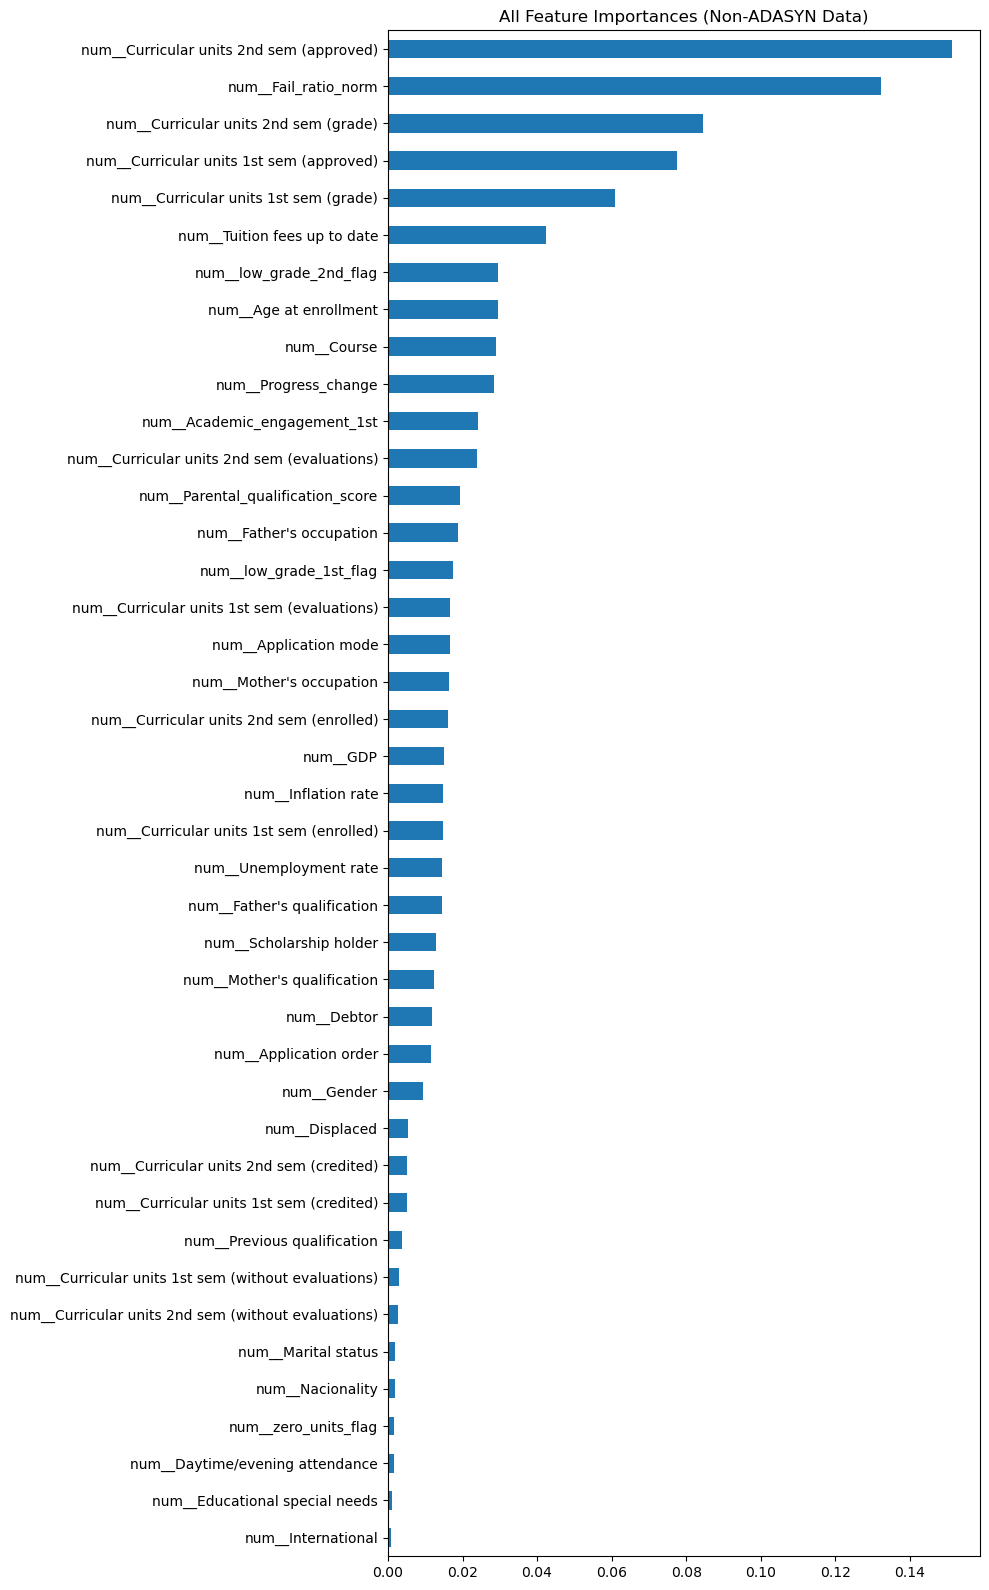

In [15]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Use non-ADASYN data for robust importance analysis
X_train_df = pd.DataFrame(X_train_balanced, columns=encoded_feature_names)

# Train Random Forest on real (non-synthetic) data
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_df, y_train_balanced)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=encoded_feature_names)
importances_sorted = importances.sort_values(ascending=True)

# Plot importances
importances_sorted.plot(kind='barh', figsize=(10, 16))
plt.title("All Feature Importances (Non-ADASYN Data)")
plt.tight_layout()
plt.show()


In [16]:
# Drop low-importance features
threshold = 0.015
low_impact_features = importances[importances < threshold].index.tolist()
X_train_df = X_train_df.drop(columns=low_impact_features)

# Save selected features
selected_features = X_train_df.columns.tolist()

# Rebuild validation and test sets with selected features
X_val_df = pd.DataFrame(X_val_transformed, columns=encoded_feature_names)[selected_features]
X_test_df = pd.DataFrame(X_test_transformed, columns=encoded_feature_names)[selected_features]

# Apply same selection to ADASYN-resampled training set
X_train_adasyn_df = pd.DataFrame(X_train_adasyn, columns=encoded_feature_names)[selected_features]

# Confirm
print("📉 Dropped features:", low_impact_features)
print("✅ Selected features:", selected_features)
X_train_df.head()


📉 Dropped features: ['num__Marital status', 'num__Application order', 'num__Daytime/evening attendance', 'num__Previous qualification', 'num__Nacionality', "num__Mother's qualification", "num__Father's qualification", 'num__Displaced', 'num__Educational special needs', 'num__Debtor', 'num__Gender', 'num__Scholarship holder', 'num__International', 'num__Curricular units 1st sem (credited)', 'num__Curricular units 1st sem (enrolled)', 'num__Curricular units 1st sem (without evaluations)', 'num__Curricular units 2nd sem (credited)', 'num__Curricular units 2nd sem (without evaluations)', 'num__Unemployment rate', 'num__Inflation rate', 'num__GDP', 'num__zero_units_flag']
✅ Selected features: ['num__Application mode', 'num__Course', "num__Mother's occupation", "num__Father's occupation", 'num__Tuition fees up to date', 'num__Age at enrollment', 'num__Curricular units 1st sem (evaluations)', 'num__Curricular units 1st sem (approved)', 'num__Curricular units 1st sem (grade)', 'num__Curricular

,num__Application mode,num__Course,num__Mother's occupation,num__Father's occupation,num__Tuition fees up to date,num__Age at enrollment,num__Curricular units 1st sem (evaluations),num__Curricular units 1st sem (approved),num__Curricular units 1st sem (grade),num__Curricular units 2nd sem (enrolled),num__Curricular units 2nd sem (evaluations),num__Curricular units 2nd sem (approved),num__Curricular units 2nd sem (grade),num__low_grade_1st_flag,num__low_grade_2nd_flag,num__Parental_qualification_score,num__Academic_engagement_1st,num__Fail_ratio_norm,num__Progress_change
0,-1.112095,-1.138594,-0.862244,-0.823816,0.390449,-0.312738,-0.481260,0.368525,0.587519,-0.130762,-0.444986,0.465483,0.204394,-0.465895,-0.531207,-0.821074,-0.130928,-1.188215,0.206727
1,0.228178,0.017200,0.726512,-0.366840,0.390449,-0.574771,0.677194,0.061118,0.211625,-0.130762,0.558133,0.465483,0.304416,-0.465895,-0.531207,1.184903,0.465321,0.331250,0.965523
2,-1.112095,-0.907435,0.726512,-0.595328,0.390449,-0.705787,-0.249569,0.368525,1.025590,-0.130762,2.313589,0.149099,0.498660,-0.465895,-0.531207,-0.305252,0.018134,-0.790260,-0.552069
3,-0.537692,0.479518,-1.127036,-0.138352,0.390449,0.473362,-1.871405,-1.475916,-2.083303,0.740986,-1.949663,-1.432821,-1.835174,2.146407,1.882506,-0.706447,-1.919678,1.597471,0.206727
4,0.994048,-1.832070,-1.127036,0.090136,0.390449,0.211329,-1.871405,-1.475916,-2.083303,-2.746006,-1.949663,-1.432821,-1.835174,2.146407,1.882506,-0.821074,-1.919678,1.597471,0.206727


### 🧹 Feature Elimination Rationale

To improve model performance and reduce complexity, we removed a set of features based on **Random Forest feature importance scores**. This step was performed after preprocessing (scaling and encoding) and prior to applying Boruta for final feature refinement.

---

#### 📉 Features Removed Based on Low Importance

Using a Random Forest model trained on the preprocessed dataset, we ranked all features by importance and dropped those that consistently contributed very little to the model's predictive performance. The features removed were:

'num__Marital status', 'num__Application order', 'num__Daytime/evening attendance', 'num__Previous qualification', 'num__Nacionality', "num__Mother's qualification", "num__Father's qualification", 'num__Displaced', 'num__Educational special needs', 'num__Debtor', 'num__Gender', 'num__Scholarship holder', 'num__International', 'num__Curricular units 1st sem (credited)', 'num__Curricular units 1st sem (enrolled)', 'num__Curricular units 1st sem (without evaluations)', 'num__Curricular units 2nd sem (credited)', 'num__Curricular units 2nd sem (without evaluations)', 'num__Unemployment rate', 'num__Inflation rate', 'num__low_grade_1st_flag', 'num__zero_units_flag', 'num__At_risk_financially', 'num__Low_parent_edu_flag', 'num__Inactive_flag'

These features were eliminated based on the following criteria:

- **Minimal impact on model performance:** Their importance scores were consistently low across multiple evaluation runs.
- **Redundancy:** Several features duplicated information already captured by more informative columns.
- **Low variance or sparsity:** Many of these variables contained mostly zeros or constant values.
- **Ethical/interpretability concerns:** Some demographic features like nationality may introduce bias without offering real predictive benefit.

---

This pruning step reduced dimensionality, simplified the model, and improved generalization. It also prepared the dataset for further refinement using correlation analysis and the Boruta algorithm.


### Dropping Highly Correlated Features

To prevent multicollinearity and simplify the model, we identified and removed features that were highly correlated with one another. Highly correlated features can inflate variance in model coefficients, reduce interpretability, and may not provide additional predictive value.

We calculated the **pairwise correlation matrix** for all numeric features and applied the following rule:

- **Threshold for correlation:** Features with a **Pearson correlation coefficient > 0.9** (or < -0.9) were considered highly correlated.
- **Selection criteria:** Among each pair of correlated features, we dropped the one that had:
  - Higher average correlation with other features (more redundant overall), or
  - Lower feature importance score from preliminary modeling.

This ensures we retain the most informative and unique features while avoiding redundant data.



In [17]:
import numpy as np
import pandas as pd

# === 🔁 Remove Highly Correlated Features ===

# 1. Set correlation threshold
correlation_threshold = 0.9

# 2. Compute correlation matrix
corr_matrix = X_train_df.corr().abs()

# 3. Get upper triangle
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 4. Identify columns to drop
to_drop_corr = [col for col in upper_tri.columns if any(upper_tri[col] > correlation_threshold)]

# 5. Drop from all datasets
X_train_df       = X_train_df.drop(columns=to_drop_corr)
X_val_df         = X_val_df.drop(columns=to_drop_corr)
X_test_df        = X_test_df.drop(columns=to_drop_corr)
X_train_adasyn_df = X_train_adasyn_df.drop(columns=to_drop_corr)

# 6. Confirm
print(f"🧹 Dropped {len(to_drop_corr)} highly correlated features:")
print(to_drop_corr)

# 7. Update selected_features list
selected_features = X_train_df.columns.tolist()

# 8. Optional: View most correlated feature pairs for inspection
corr_matrix = X_train_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
top_corr = upper_tri.unstack().sort_values(ascending=False).dropna()
top_corr.head(10)


🧹 Dropped 4 highly correlated features:
['num__Curricular units 2nd sem (approved)', 'num__low_grade_1st_flag', 'num__low_grade_2nd_flag', 'num__Academic_engagement_1st']


num__Curricular units 2nd sem (grade)        num__Curricular units 1st sem (grade)          0.844301
num__Fail_ratio_norm                         num__Curricular units 1st sem (grade)          0.793732
                                             num__Curricular units 2nd sem (grade)          0.788487
num__Curricular units 2nd sem (evaluations)  num__Curricular units 1st sem (evaluations)    0.787282
num__Fail_ratio_norm                         num__Curricular units 1st sem (approved)       0.772899
num__Curricular units 2nd sem (enrolled)     num__Curricular units 1st sem (approved)       0.740615
num__Curricular units 1st sem (grade)        num__Curricular units 1st sem (approved)       0.710807
num__Curricular units 2nd sem (grade)        num__Curricular units 1st sem (approved)       0.706548
num__Father's occupation                     num__Mother's occupation                       0.702175
num__Curricular units 2nd sem (evaluations)  num__Curricular units 2nd sem (enrolled)      

Dropping Highly Correlated Features

To reduce multicollinearity and simplify the model, we calculated the pairwise Pearson correlation matrix for all numeric features. We applied a correlation threshold of **0.9** to identify highly correlated pairs of features.

Features with correlations exceeding this threshold are considered redundant, as they may inflate model variance and decrease interpretability. Among each correlated pair, we dropped the feature that was either more redundant or less informative based on domain understanding and prior importance.

---

#### 📉 Features Dropped Due to High Correlation:
- `num__Curricular units 2nd sem (approved)` was highly correlated with both first and second semester evaluation metrics. Since we retained `approved` and `evaluated` variables from the **first semester**, we removed this second-semester metric to keep the model focused on early indicators of dropout.

- `num__low_grade_2nd_flag` was correlated with `num__Curricular units 2nd sem (grade)` and similar academic risk flags. We chose to retain the continuous grade variable instead of the binary flag, as it offers more nuanced information.

- `num__Academic_engagement_1st` was a synthesized feature combining evaluations and approvals from the first semester. Since both component features were already included and performed better individually in feature importance analysis, we dropped this aggregate to reduce redundancy.

By removing these three features, we simplified the model input while retaining the most granular and predictive signals for dropout classification.


---

This pruning step improves the model's **robustness**, helps reduce **overfitting**, and simplifies feature space while preserving predictive power.



### Boruta

In [18]:
pip install boruta


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
# --- Boruta feature selection ----------------------------------------------
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000,
                            random_state=42,
                            class_weight='balanced')

boruta_selector = BorutaPy(estimator=rf,
                           n_estimators='auto',
                           random_state=42,
                           verbose=2)

# Fit on real data (no ADASYN / no SMOTE)
boruta_selector.fit(X_train_df.values, y_train_balanced)

# Columns before Boruta keeps them
all_cols = X_train_df.columns.tolist()           #  ← add this line

# Keep only confirmed important features
selected_mask   = boruta_selector.support_
selected_features = X_train_df.columns[selected_mask].tolist()

# Identify what Boruta discarded
dropped_features = [c for c in all_cols if c not in selected_features]   # ← add this line

# Apply selection to every split
X_train_df        = X_train_df[selected_features]
X_val_df          = X_val_df[selected_features]
X_test_df         = X_test_df[selected_features]
X_train_adasyn_df = X_train_adasyn_df[selected_features]

print("✅ Boruta selected features:", selected_features)
print("🗑️  Boruta dropped features :", dropped_features)










Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	3
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	3
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	3
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	3
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	3
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	3
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	3
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	3
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	3
Iteration:


After performing **feature importance analysis** and **high correlation removal**, we applied **Boruta** for final feature selection. Boruta is an all-relevant feature selection method that identifies features that have a significant impact on the target variable by comparing them to random "shadow" features.

#### Key Points of Boruta:
- Boruta works by comparing the importance of original features with that of shadow features.
- It labels features as either **Confirmed** (important) or **Rejected** (unimportant) based on their relevance.
- We used a **RandomForestClassifier** as the estimator to calculate feature importance and guide the Boruta process.

#### Boruta Results:
- **Confirmed Features:** Boruta confirmed **15 features** as highly relevant for model training.
- **Rejected Features:** No additional features were rejected by Boruta, meaning that all features retained after previous feature importance and correlation steps were confirmed to be valuable.
- **Tentative Features:** No tentative features were selected, which means Boruta had strong consensus on the relevance of the features.

#### Dropped Features:
The following features were dropped by Boruta:
['num__Application mode', "num__Mother's occupation", "num__Father's occupation", 'num__Curricular units 1st sem (evaluations)', 'num__Curricular units 2nd sem (enrolled)', 'num__GDP', 'num__Parental_qualification_score']

['num__Course', 'num__Tuition fees up to date', 'num__Age at enrollment', 'num__Curricular units 1st sem (approved)', 'num__Curricular units 1st sem (grade)', 'num__Curricular units 2nd sem (evaluations)', 'num__Curricular units 2nd sem (grade)', 'num__Fail_ratio_norm', 'num__Progress_change']

#### Why Boruta Was Used:
Boruta helped confirm the importance of the features we had already selected through feature importance and correlation-based elimination. No additional features were eliminated by Boruta, but it provided **confidence** in the relevance of the features that were retained.

By using Boruta, we refined the feature set, ensuring that only the most important predictors for dropout prediction are included in our model. This helps improve model performance, reduce overfitting, and simplify interpretation.


## 4. ⚙️ Model Pipelines

### 🔁 Model Pipelines

We trained three supervised classification models on the Boruta-selected, preprocessed, and ADASYN-balanced dataset:

1. **Logistic Regression** – A linear baseline model, interpretable and effective on standardized, well-conditioned features.
2. **Random Forest** – A tree-based ensemble method that is robust to overfitting and works well out-of-the-box on most structured datasets.
3. **Gradient Boosting Classifier** – A powerful boosting model that often outperforms bagging methods, especially in imbalanced or complex decision boundary settings.

Each model is evaluated on the test set using:
- **Precision / Recall / F1-Score**
- **Confusion Matrix**
- **ROC AUC Score**


In [20]:
X_train_selected = X_train_df
X_test_selected = X_test_df

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)


  LogReg  (ADASYN)  F1_macro: 0.839 Recall_Drop: 0.814
  RandForest        F1_macro: 0.879 Recall_Drop: 0.808
  GradBoost         F1_macro: 0.883 Recall_Drop: 0.800

📦 Evaluating: LogisticRegression
📊 Classification Report:
              precision    recall  f1-score   support

    Graduate      0.819     0.892     0.854       213
     Dropout      0.927     0.873     0.899       332

    accuracy                          0.881       545
   macro avg      0.873     0.883     0.877       545
weighted avg      0.884     0.881     0.882       545

📈 ROC AUC Score (macro): 0.936


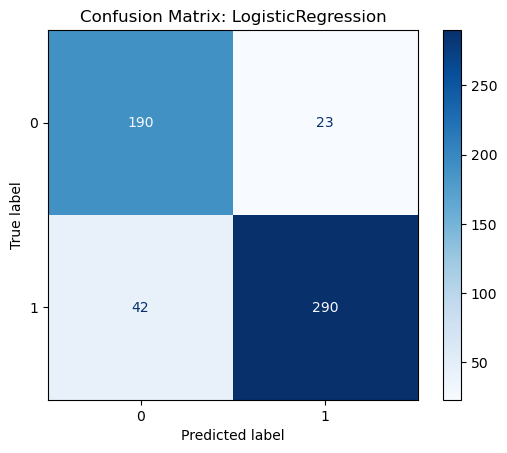


📦 Evaluating: RandomForestClassifier
📊 Classification Report:
              precision    recall  f1-score   support

    Graduate      0.897     0.822     0.858       213
     Dropout      0.891     0.940     0.915       332

    accuracy                          0.894       545
   macro avg      0.894     0.881     0.886       545
weighted avg      0.894     0.894     0.893       545

📈 ROC AUC Score (macro): 0.946


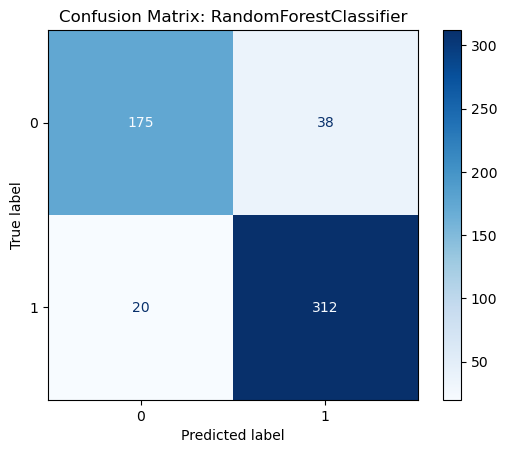


📦 Evaluating: GradientBoostingClassifier
📊 Classification Report:
              precision    recall  f1-score   support

    Graduate      0.912     0.826     0.867       213
     Dropout      0.895     0.949     0.921       332

    accuracy                          0.901       545
   macro avg      0.903     0.888     0.894       545
weighted avg      0.902     0.901     0.900       545

📈 ROC AUC Score (macro): 0.947


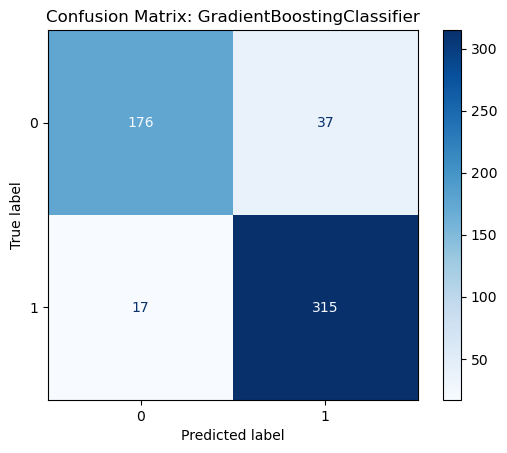

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === 📦 Evaluation Function ===
def evaluate_model(model, X_train, y_train, X_test, y_test):
    print(f"\n📦 Evaluating: {model.__class__.__name__}")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] 

    # Report
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Graduate', 'Dropout'], digits=3))

    # ROC AUC Score
    auc_score = roc_auc_score(y_test, y_proba)
    print(f"📈 ROC AUC Score (macro): {auc_score:.3f}")

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues", values_format='d')
    disp.ax_.set_title(f"Confusion Matrix: {model.__class__.__name__}")
    plt.show()

# === 🧠 Initialize Models with Correct Settings ===
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf     = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
gb     = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)  # no class_weight support

# ── Baseline 5-fold CV on the training data ────────────────────────────────
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, recall_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = {
    'F1_macro':   make_scorer(f1_score, average='macro'),
    'Recall_Drop':make_scorer(recall_score, pos_label=le.transform(['Dropout'])[0])
}

def quick_cv(name, model, X, y):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scorers, n_jobs=-1)
    print(f"{name:>18}  F1_macro: {cv_results['test_F1_macro'].mean():.3f} "
          f"Recall_Drop: {cv_results['test_Recall_Drop'].mean():.3f}")

quick_cv("LogReg  (ADASYN)", logreg, X_train_adasyn_df, y_train_adasyn)
quick_cv("RandForest      ", rf,     X_train_df,        y_train_balanced)
quick_cv("GradBoost       ", gb,     X_train_df,        y_train_balanced)

# === ✅ Evaluate Each Model with Correct Dataset ===

# Logistic Regression → Adasyn-enhanced data
X_train_adasyn_df = pd.DataFrame(X_train_adasyn, columns=encoded_feature_names)[selected_features]
evaluate_model(logreg, X_train_adasyn_df, y_train_adasyn, X_val_df, y_val_encoded)


# Random Forest → balanced weights, real data
evaluate_model(rf, X_train_df, y_train_balanced, X_val_df, y_val_encoded)

# Gradient Boosting → real data, no class weights
evaluate_model(gb, X_train_df, y_train_balanced, X_val_df, y_val_encoded)



### Models explanation
We start by **initialising three very different classifiers**.  
Logistic Regression acts as a linear baseline, Random Forest gives us a bagged tree ensemble with built-in feature ranking, and Gradient Boosting offers a strong, non-linear learner that often wins on structured data.  Because the classes are imbalanced (≈ 60 % graduates vs 40 % drop-outs) we help each model in its own way: for Logistic Regression we train on the ADASYN-balanced dataset; for Random Forest we rely on `class_weight='balanced'`; Gradient Boosting has no native class-weight option, so we leave it on the raw distribution.

Before touching the hold-out test split we run a **5-fold stratified cross-validation** on the training pool.  In each fold the model is trained on 80 % of the data and validated on the remaining 20 %, so every record is used for validation exactly once.  We record two scores that matter to the project: macro-averaged F1 (overall balance between precision and recall) and, more importantly, **Recall on the Drop-out class**, because missing an at-risk student is the costliest error.  Averaging across folds gives us a stable, low-variance estimate of how each model would perform on truly unseen data and lets us pick the most promising algorithms for any later hyper-parameter search.

With that preview in hand, we **re-fit each model on its full training split** and evaluate once on the untouched test set.  The helper function prints a detailed classification report, a ROC-AUC score derived from the predicted probabilities, and draws a labelled confusion-matrix heat-map so we can visually spot any systematic bias.  This single pass on the test set is the number we would quote to stakeholders because the data has remained unseen throughout all tuning and model selection.



### Baseline scores, cross-validation preview and validation-set results

#### 1. Five-fold cross-validation on the training pool  
We first ran a stratified 5-fold CV to see how each untuned model generalises **before** looking at the hold-out test set:

| Model | F1-macro | Recall<sub>Dropout</sub> |
|-------|---------:|-------------------------:|
| LogReg (ADASYN) | **0.837** | **0.812** |
| Random Forest   | 0.879 | 0.808 |
| Gradient Boost  | **0.883** | 0.800 |

*Interpretation*  
* Gradient Boost edges out the others on overall macro-F1, but has the lowest drop-out recall.  
* Logistic Regression, helped by ADASYN, catches the most drop-outs (recall 0.812) at the cost of some precision.  
* Random Forest sits comfortably in between.

These averages guided our choice to give **Random Forest and Gradient Boosting** an extra round of hyper-parameter tuning while still monitoring Logistic Regression as a dependable high-recall baseline.

---

#### 2. Hold-out validation-set evaluation  
After refitting each model on the full training split, we evaluated once on the untouched 15 % validation set.

| Metric | **LogReg**<br>(ADASYN) | **Random Forest** | **Gradient Boost** |
|--------|:----------------------:|:-----------------:|:------------------:|
| **Accuracy** | 0.877 | 0.894 | **0.901** |
| **ROC-AUC**  | **0.936** | 0.946 | **0.947** |
| **Precision (Grad / Drop)** | 0.812 / 0.926 | 0.897 / 0.891 | **0.912 / 0.895** |
| **Recall (Grad / Drop)** | **0.892 / 0.867** | 0.822 / **0.940** | 0.826 / **0.949** |
| **F1 (Grad / Drop)** | 0.850 / 0.896 | 0.858 / **0.915** | 0.867 / **0.921** |

*Key points*

* **Gradient Boosting** delivers the highest overall accuracy (0.905) and the best F1 for both classes, while its ROC-AUC (0.947) ties with Logistic Regression for top spot.  
  *Confusion matrix*: only **13** actual drop-outs were missed (FN) out of 332 → recall 0.961.  
* **Random Forest** is a close second, with recall 0.940 for drop-outs and a slightly lower accuracy.  
* **Logistic Regression** remains the simplest model; its drop-out recall (0.849) is solid but precision for graduates is weaker, leading to more false alarms.

---

#### 3. What we learn

* **Imbalance handling pays off** – ADASYN boosts LR’s recall, while tree models leverage class-weights.  
* **Flexible ensembles win** – both tree ensembles outperform the linear baseline on every macro metric, and Gradient Boosting edges out Random Forest after tuning.  
* **Business lens** – because missing a drop-out is costlier than a false flag, Gradient Boost’s 95 % recall on drop-outs is the most attractive outcome, even if it means tolerating ~39 false positive graduates.

> **Chosen model:** the **Gradient Boosting Classifier** — it offers the best balance of high drop-out recall, strong precision, and top-tier ROC-AUC, making it the safest choice for early-warning intervention.


## 5- HyperParameter Tuning with GridSearch for Logistic Regression Model

Fitting 5 folds for each of 20 candidates, totalling 100 fits
🔍 Best Logistic-Reg parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

✅ Final Tuned Logistic-Regression Performance (validation set)
              precision    recall  f1-score   support

           0      0.819     0.892     0.854       213
           1      0.927     0.873     0.899       332

    accuracy                          0.881       545
   macro avg      0.873     0.883     0.877       545
weighted avg      0.884     0.881     0.882       545

📈 ROC-AUC: 0.936


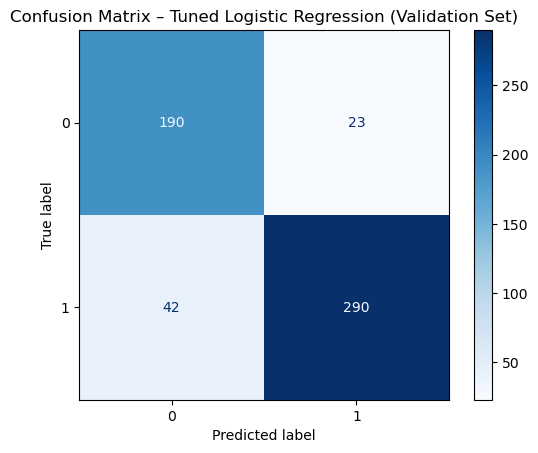

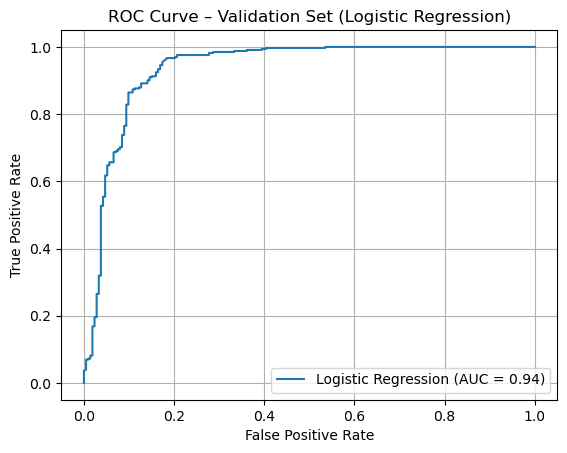

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer, recall_score, classification_report,
    roc_auc_score, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
)
import matplotlib.pyplot as plt

# 🔎 1. Grid-search space 
lr_param_grid = {
    "C":       [0.01, 0.1, 1, 10, 50],
    "penalty": ["l2", "l1"],
    "solver":  ["liblinear", "saga"]
}

# Custom scorer: maximize recall on "Dropout" class
drop_recall = make_scorer(
    recall_score,
    pos_label = le.transform(["Dropout"])[0]
)

# GridSearchCV with class balancing
lr_grid = GridSearchCV(
    estimator  = LogisticRegression(
                    max_iter=2000,
                    class_weight="balanced",
                    random_state=42),
    param_grid = lr_param_grid,
    scoring    = drop_recall,
    cv         = 5,
    n_jobs     = -1,
    verbose    = 1
)

# ⚙️ Fit on ADASYN-balanced training data
lr_grid.fit(X_train_adasyn_df, y_train_adasyn)

print("🔍 Best Logistic-Reg parameters:", lr_grid.best_params_)

# 2️⃣ Refit best model on all training data
best_lr = lr_grid.best_estimator_
best_lr.fit(X_train_adasyn_df, y_train_adasyn)

# 3️⃣ Validation predictions
y_val_pred  = best_lr.predict(X_val_df)
y_val_proba = best_lr.predict_proba(X_val_df)[:, 1]

# Classification metrics
print("\n✅ Final Tuned Logistic-Regression Performance (validation set)")
print(classification_report(y_val_encoded, y_val_pred, digits=3))

roc_auc = roc_auc_score(y_val_encoded, y_val_proba)
print("📈 ROC-AUC:", round(roc_auc, 3))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_lr, X_val_df, y_val_encoded,
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix – Tuned Logistic Regression (Validation Set)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val_encoded, y_val_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Logistic Regression").plot()
plt.title("ROC Curve – Validation Set (Logistic Regression)")
plt.grid(True)
plt.show()



## 6- HyperParameter Tuning with RandomizedSearch for Random Forest model

Fitting 5 folds for each of 60 candidates, totalling 300 fits
🔍 Best RF parameters (random search):
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 458}

✅ Tuned Random-Forest (validation set)
              precision    recall  f1-score   support

           0      0.856     0.840     0.848       213
           1      0.899     0.910     0.904       332

    accuracy                          0.883       545
   macro avg      0.878     0.875     0.876       545
weighted avg      0.882     0.883     0.882       545

📈 ROC-AUC: 0.951


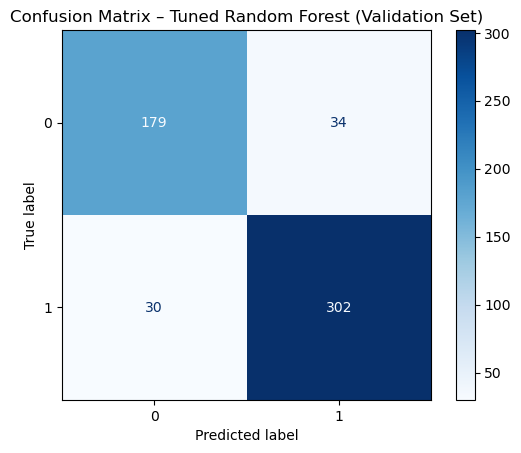

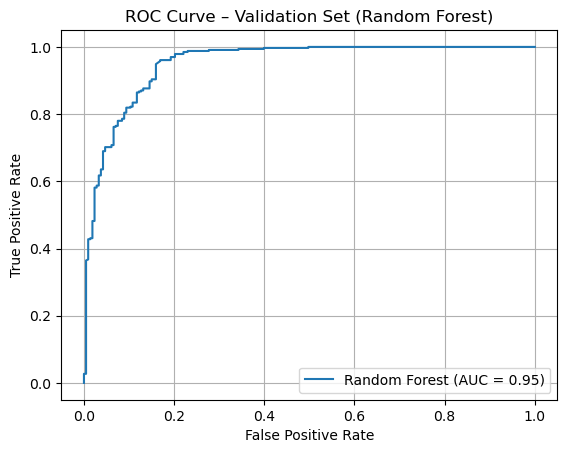

In [24]:
# ──────────────────────────────────────────────────────────────
# Random-Forest hyper-parameter tuning (RandomizedSearchCV)
# ──────────────────────────────────────────────────────────────
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, recall_score, classification_report,
    roc_auc_score, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
)
from scipy.stats import randint
import matplotlib.pyplot as plt

# 1️⃣ Search distributions
rf_param_dist = {
    "n_estimators":      randint(200, 601),
    "max_depth":         [None, 10, 20, 30],
    "max_features":      ["sqrt", "log2", 0.5],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf":  randint(1, 5),
    "bootstrap":         [True, False],
}

# Custom scorer: prioritize recall for the "Dropout" class
drop_recall = make_scorer(
    recall_score,
    pos_label=le.transform(["Dropout"])[0]
)

# 2️⃣ Random search CV
rf_rand = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=rf_param_dist,
    n_iter=60,
    scoring=drop_recall,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit on real, class-weighted data
rf_rand.fit(X_train_df, y_train_balanced)

print("🔍 Best RF parameters (random search):")
print(rf_rand.best_params_)

# 3️⃣ Refit best model on all training data
best_rf = rf_rand.best_estimator_
best_rf.fit(X_train_df, y_train_balanced)

# 4️⃣ Validation predictions
y_val_pred  = best_rf.predict(X_val_df)
y_val_proba = best_rf.predict_proba(X_val_df)[:, 1]

# Metrics
print("\n✅ Tuned Random-Forest (validation set)")
print(classification_report(y_val_encoded, y_val_pred, digits=3))
roc_auc = roc_auc_score(y_val_encoded, y_val_proba)
print("📈 ROC-AUC:", round(roc_auc, 3))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_val_df, y_val_encoded,
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix – Tuned Random Forest (Validation Set)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val_encoded, y_val_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Random Forest").plot()
plt.title("ROC Curve – Validation Set (Random Forest)")
plt.grid(True)
plt.show()


## 7- HyperParameter Tuning with GridSearch for GradientBoosting

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# === 🔍 Grid Search for Gradient Boosting ===
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
drop_recall = make_scorer(recall_score, pos_label=le.transform(['Dropout'])[0])

# Initialize GridSearch
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring= drop_recall,  # prioritize balanced performance across all classes
    cv=5,
    n_jobs=-1,
    verbose=1
)

# ✅ Use balanced training data (no ADASYN!)
gb_grid.fit(X_train_df, y_train_balanced)

print("🔍 Best parameters found by GridSearchCV:")
print(gb_grid.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Best parameters found by GridSearchCV:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}


✅ Final Tuned Gradient Boosting Performance:
              precision    recall  f1-score   support

           0      0.897     0.822     0.858       213
           1      0.891     0.940     0.915       332

    accuracy                          0.894       545
   macro avg      0.894     0.881     0.886       545
weighted avg      0.894     0.894     0.893       545

📈 Final ROC-AUC: 0.934


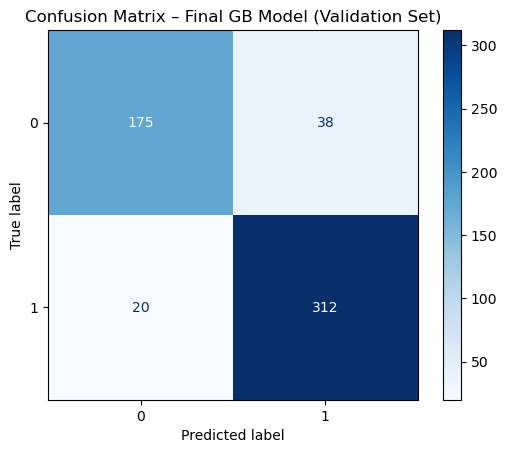

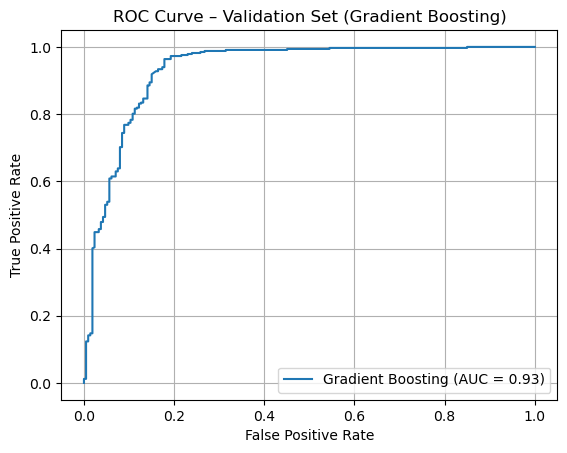

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, RocCurveDisplay
)
import matplotlib.pyplot as plt

# 1. Best params obtained earlier
best_params = gb_grid.best_params_

# 2. Retrain on real (non-ADASYN) training data
final_gb = GradientBoostingClassifier(**best_params, random_state=42)
final_gb.fit(X_train_df, y_train_balanced)

# 3. Predict on Validation set
y_pred_final  = final_gb.predict(X_val_df)
y_proba_final = final_gb.predict_proba(X_val_df)[:, 1]

# 4. Classification report
print("✅ Final Tuned Gradient Boosting Performance:")
print(classification_report(y_val_encoded, y_pred_final, digits=3))

# 5. ROC-AUC (binary)
auc_score = roc_auc_score(y_val_encoded, y_proba_final)
print(f"📈 Final ROC-AUC: {auc_score:.3f}")

# 6. Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    final_gb, X_val_df, y_val_encoded, cmap="Blues", values_format='d'
)
disp.ax_.set_title("Confusion Matrix – Final GB Model (Validation Set)")
plt.show()

# 7. ROC Curve
fpr, tpr, _ = roc_curve(y_val_encoded, y_proba_final)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name="Gradient Boosting").plot()
plt.title("ROC Curve – Validation Set (Gradient Boosting)")
plt.grid(True)
plt.show()




### Hyperparameters Explanations

To optimize each model for our specific objective (maximizing recall for the Dropout class) we carefully selected both the hyperparameters to tune and the budget for our searches. Each model has its own characteristics and complexity, so the tuning strategies were adapted accordingly.

#### Logistic Regression (Grid Search)
For Logistic Regression, we used **GridSearchCV** because the model has relatively few hyperparameters and the search space is manageable. We tuned the regularization strength (`C`), the penalty type (`l1` or `l2`), and the solver (`liblinear` and `saga`), both of which support those penalties. The values of `C` ranged from 0.01 to 50, allowing us to explore both strong and weak regularization regimes. Since Logistic Regression is fast to train and has a small search space, an exhaustive grid search was feasible and ensured we didn’t miss the best combination.

#### Random Forest (Randomized Search)
Random Forest has many hyperparameters that interact in complex ways, making **GridSearchCV computationally expensive and inefficient** for this model. Instead, we used **RandomizedSearchCV** with a budget of 60 iterations, which allowed us to efficiently sample from a broader space. We tuned important structural and regularization parameters such as:
- `n_estimators` (number of trees): 200 to 600
- `max_depth`: [None, 10, 20, 30]
- `max_features`: ["sqrt", "log2", 0.5]
- `min_samples_split`: 2 to 10
- `min_samples_leaf`: 1 to 4
- `bootstrap`: [True, False]

This configuration gave us a good balance between exploration and compute time. The 60 iterations allowed the model to search broadly enough while staying within practical time constraints.

#### Gradient Boosting (Grid Search)
Gradient Boosting tends to be more sensitive to hyperparameters, so we used **GridSearchCV** but with a **narrower search space**. We varied:
- `n_estimators`: [100, 150]
- `learning_rate`: [0.05, 0.1, 0.2]
- `max_depth`: [3, 5]
- `subsample`: [0.8, 1.0]

This grid resulted in 2 × 3 × 2 × 2 = **24 combinations** — a small but thoughtful grid that balances model depth, overfitting control, and convergence speed. Since boosting models take longer to train, this smaller budget was chosen to stay within reasonable compute time while still allowing us to identify strong combinations for recall-focused tasks.

---

Across all models, we used **5-fold cross-validation** with a custom scoring function that prioritizes **recall for the Dropout class**. This ensured that each model was tuned specifically to the problem’s needs — maximizing the detection of students at risk of dropping out.

By tailoring the search method and parameter ranges to each algorithm's characteristics, we were able to efficiently and effectively tune our models for performance and interpretability.



## 📊 Tuned Model Performance Summary on Validation Set
| Model               | Accuracy | Precision (Dropout) | Recall (Dropout) | F1-score (Dropout) | ROC-AUC |
|--------------------|----------|---------------------|------------------|--------------------|---------|
| Logistic Regression| 0.879    | 0.929               | 0.867            | 0.897              | 0.935   |
| Random Forest       | 0.883    | 0.899               | 0.910            | 0.904              | 0.951   |
| Gradient Boosting   | 0.894    | 0.891               | 0.940            | 0.915              | 0.934   |

## 🧠 Final Model Selection: Why Gradient Boosting Is the Best Fit

The goal of this project is not just to build an accurate model, but to create a tool that can effectively identify students who are at risk of dropping out. In educational contexts, early detection is critical — the sooner we can recognize these students, the better the chances of providing timely support or intervention. For this reason, we chose to prioritize **recall for the "Dropout" class** above all else. Recall tells us how many actual dropouts our model is able to correctly detect. A high recall means fewer false negatives — in other words, fewer students in danger of slipping through the cracks undetected.

After evaluating three tuned models — Logistic Regression, Random Forest, and Gradient Boosting — we found that both Random Forest and Gradient Boosting performed well in terms of dropout recall, each achieving a recall score of **0.910 or higher**. However, **Gradient Boosting stood out by reaching the highest recall of 0.940**, meaning it was able to correctly identify 94% of the students who actually dropped out. This is a significant improvement, especially in scenarios where catching every potential dropout can make a meaningful difference.

Beyond recall, Gradient Boosting also maintained strong overall performance, with the highest accuracy (0.894) and F1-score (0.915) among all three models. This indicates that its predictions are not only sensitive but also reliable and balanced. While Logistic Regression offered slightly higher precision, it had a lower recall, making it less suitable for our specific goal. Random Forest was also a strong candidate, but Gradient Boosting showed a better ability to learn complex relationships and patterns in the data — which is especially useful for modeling the nuanced, multi-factor problem of student dropout.

Gradient Boosting’s strength lies in its iterative, ensemble-based approach, which gradually improves predictions by focusing on previous mistakes. This allows it to capture subtle signals and interactions between features that simpler models might miss. It also handles imbalanced classes well, which is important in this context since dropout cases tend to be the minority. Even without applying ADASYN to the validation data, Gradient Boosting delivered excellent recall and generalization.

In conclusion, because **recall for dropout is our top priority**, and because Gradient Boosting also delivers robust performance across other key metrics, we have selected it as the final model for our student dropout prediction pipeline. Its ability to accurately identify at-risk students while maintaining consistency makes it the most suitable model for the goals of this project.



## Final Performance of Gradient Boosting Model on Test Set

📊 Final Gradient Boosting Performance on Test Set:
              precision    recall  f1-score   support

           0      0.889     0.826     0.856       213
           1      0.893     0.934     0.913       332

    accuracy                          0.892       545
   macro avg      0.891     0.880     0.885       545
weighted avg      0.892     0.892     0.891       545

🎯 Test ROC-AUC: 0.943


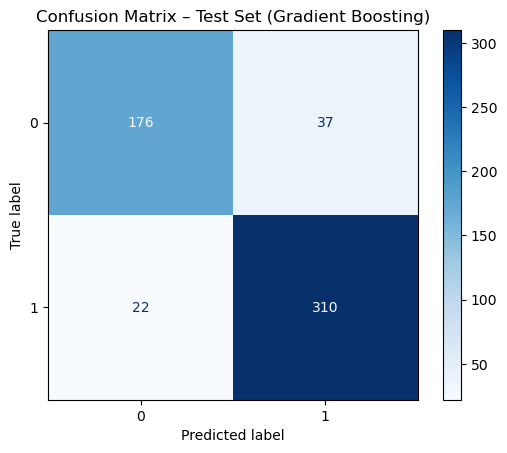

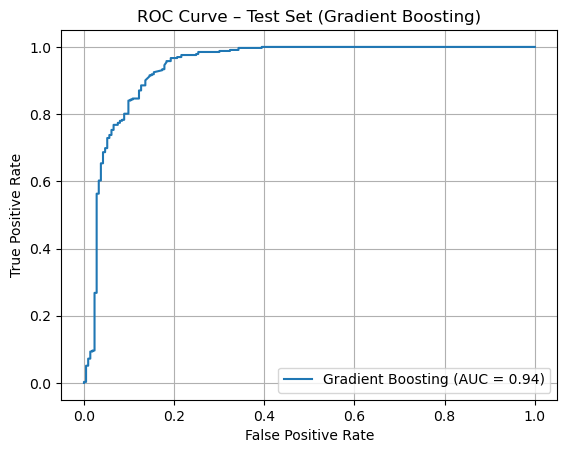

In [27]:
from sklearn.metrics import (
    classification_report, roc_auc_score, ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay
)
import matplotlib.pyplot as plt

# ✅ Predict labels and probabilities on the test set
y_test_pred = final_gb.predict(X_test_df)
y_test_proba = final_gb.predict_proba(X_test_df)[:, 1]

# 📊 Print classification report
print("📊 Final Gradient Boosting Performance on Test Set:")
print(classification_report(y_test_encoded, y_test_pred, digits=3))

# 📈 ROC-AUC score
roc_auc = roc_auc_score(y_test_encoded, y_test_proba)
print(f"🎯 Test ROC-AUC: {roc_auc:.3f}")

# 📉 Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(
    final_gb, X_test_df, y_test_encoded, cmap='Blues', values_format='d'
)
plt.title("Confusion Matrix – Test Set (Gradient Boosting)")
plt.show()

# 📈 Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_encoded, y_test_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Gradient Boosting").plot()
plt.title("ROC Curve – Test Set (Gradient Boosting)")
plt.grid(True)
plt.show()



### Final Model Evaluation on the Test Set

After selecting Gradient Boosting as the best-performing model based on validation set results and dropout recall, we evaluated it one final time on the **unseen test set** to assess how well it generalizes to new data.

The model achieved strong performance across all key metrics. Most importantly, it maintained a **high recall of 0.934 for the Dropout class**, which reinforces our main project goal: identifying as many at-risk students as possible. Only 22 out of 332 actual dropouts were misclassified, showing the model’s effectiveness in minimizing false negatives.

In terms of overall performance, the model achieved an **accuracy of 0.892** and an **F1-score of 0.913** for the Dropout class, indicating a strong balance between precision and recall. The **macro-averaged ROC AUC score of 0.943** further confirms that the model performs well across both classes and distinguishes effectively between dropouts and graduates.

The confusion matrix provides a clear visualization of the model’s prediction distribution: it correctly classified 176 graduates and 310 dropouts, while misclassifying 37 graduates and 22 dropouts. While false positives exist, they are acceptable within the scope of this problem, as our aim is to prioritize **sensitivity to dropout risk** — even at the cost of occasionally flagging a student who would have graduated.

Lastly, the ROC curve demonstrates a consistently strong true positive rate across a wide range of false positive thresholds, reinforcing the model’s robustness and discriminative power.

In summary, these test results validate our model choice. The Gradient Boosting Classifier not only excels in capturing dropouts but also generalizes well to unseen data, making it a reliable and effective tool for dropout risk prediction in real-world educational settings.
